# EDA & Visualization

In [67]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb

from main import thresh_date_merge

## Read and prepare data

In [68]:
insitu = pd.read_csv('complete_in-situ.csv', low_memory=False)
sat = pd.read_csv('larger_landsat.csv', low_memory=False)
insitu.columns = [x.lower() for x in insitu.columns]
sat.columns = [x.lower() for x in sat.columns]
insitu['date'] = pd.to_datetime(insitu['date'])
sat['date'] = pd.to_datetime(sat['date'])
len(insitu)

23556

In [69]:
insitu = insitu[['comid', 'date', 'analyte', 'raw_value']]
insitu['analyte'] = insitu['analyte'].str.lower()
insitu['analyte'] = insitu['analyte'].apply(lambda x: 'chlorophyll' if 'chloro' in x else 'secchi')
insitu_chloro = insitu[insitu['analyte'] == 'chlorophyll']
insitu_secchi = insitu[insitu['analyte'] == 'secchi']
insitu_chloro.drop('analyte', axis=1, inplace=True)
insitu_secchi.drop('analyte', axis=1, inplace=True)
insitu_chloro.rename({'raw_value': 'chlorophyll'}, axis=1, inplace=True)
insitu_secchi.rename({'raw_value': 'secchi'}, axis=1, inplace=True)
insitu_chloro = insitu_chloro.groupby(['comid', 'date']).mean().reset_index()
insitu_secchi = insitu_secchi.groupby(['comid', 'date']).mean().reset_index()
insitu = insitu_chloro.merge(insitu_secchi, how='left')
insitu.dropna(subset=['comid', 'date', 'chlorophyll'], inplace=True)
len(insitu)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


1547

In [70]:
sat = sat[['comid', 'date', 'red', 'blue', 'green', 'areasqkm', 'distance',
           'aerosol', 'nir', 'swir1', 'swir2', 'tir1', 'tir2', 'pcount_dswe1',
           'pcount_dswe3', 'dwl']]
sat = sat.groupby(['comid', 'date']).mean().reset_index()
df = thresh_date_merge(insitu, sat, merge_cols=['comid'], thresh=1)
len(df)

143

## Exploration
Before we start creating plots, we'll add a couple simple features.

In [71]:
df['month'] = df['date'].dt.month
df['log_secchi'] = np.log(df['secchi'])

We're going to log-transform the response variable since it the distribution is highly skewed.

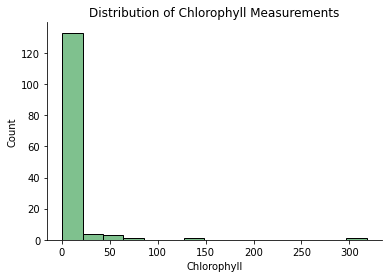

In [72]:
sb.histplot(df['chlorophyll'], color='xkcd:algae', bins=15)
sb.despine()
plt.xlabel('Chlorophyll')
plt.title('Distribution of Chlorophyll Measurements')
plt.savefig('figures/chloro_hist.png', dpi=200, bbox_inches='tight')
plt.show()

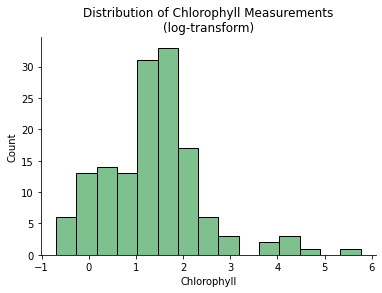

In [73]:
df['chlorophyll'] = np.log(df['chlorophyll'])

sb.histplot(df['chlorophyll'], color='xkcd:algae', bins=15)
sb.despine()
plt.xlabel('Chlorophyll')
plt.title('Distribution of Chlorophyll Measurements\n(log-transform)')
plt.savefig('figures/log_chloro_hist.png', dpi=200, bbox_inches='tight')
plt.show()

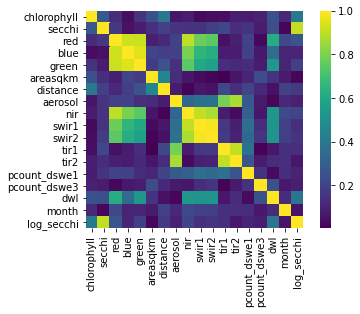

In [74]:
sb.heatmap(df.set_index(['comid', 'date']).corr().abs(), square=True, cmap='viridis')
plt.savefig('figures/corr.png', dpi=200, bbox_inches='tight')
plt.show()

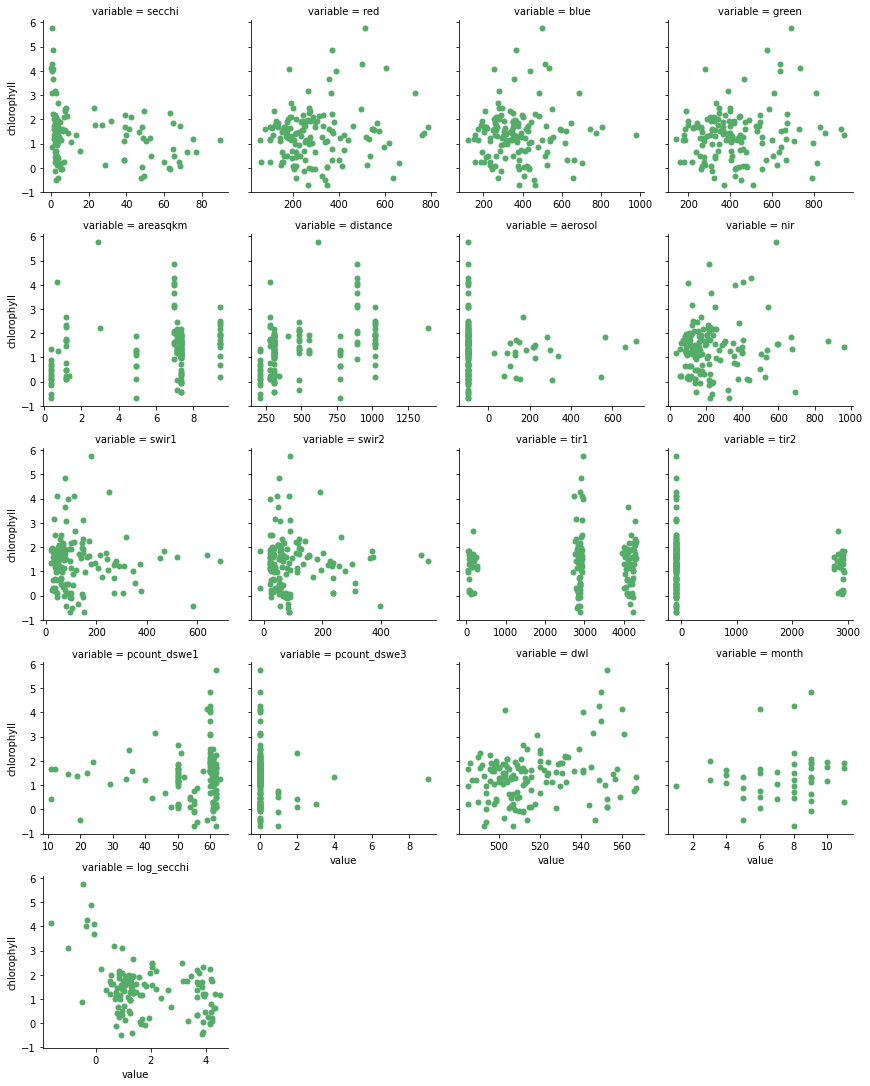

In [75]:
df_melt = df \
    .drop(['date_x', 'date_y', 'date_plus_1', 'date_minus_1'], axis=1) \
    .melt(id_vars=['comid', 'date', 'chlorophyll'])

sb.relplot(
    x='value',
    y='chlorophyll',
    col='variable',
    data=df_melt,
    col_wrap=4,
    height=3,
    color='xkcd:algae',
    linewidth=0,
    facet_kws={'sharex': False}
)
plt.savefig('figures/scatter.png', dpi=200, bbox_inches='tight')
plt.show()